In [1]:
!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install rouge_score
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import statistics
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer
import tiktoken

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv('./Group16_Final_Set_QA_csv.csv', header=0)  # upload the shared csv file

# Display the first few rows of the DataFrame
print(df.head())

                                                   Q  \
0             How would you define machine learning?   
1  Can you name four types of applications where ...   
2                    What is a labeled training set?   
3     What are the two most common supervised tasks?   
4       Can you name four common unsupervised tasks?   

                                                   A  
0  Machine Learning is about building systems tha...  
1  Machine Learning is great for complex problems...  
2  A labeled training set is a training set that ...  
3  The two most common supervised tasks are regre...  
4  Common unsupervised tasks include clustering, ...  


In [5]:
#df = df.drop(['Unnamed: 0', 'unit'], axis=1)
print(df.head())

                                                   Q  \
0             How would you define machine learning?   
1  Can you name four types of applications where ...   
2                    What is a labeled training set?   
3     What are the two most common supervised tasks?   
4       Can you name four common unsupervised tasks?   

                                                   A  
0  Machine Learning is about building systems tha...  
1  Machine Learning is great for complex problems...  
2  A labeled training set is a training set that ...  
3  The two most common supervised tasks are regre...  
4  Common unsupervised tasks include clustering, ...  


In [6]:
# find and drop 'nan' rows
print(df.isnull().sum())
df.dropna(subset=['Q', 'A'], inplace=True)
print(df.isnull().sum())

Q    0
A    0
dtype: int64
Q    0
A    0
dtype: int64


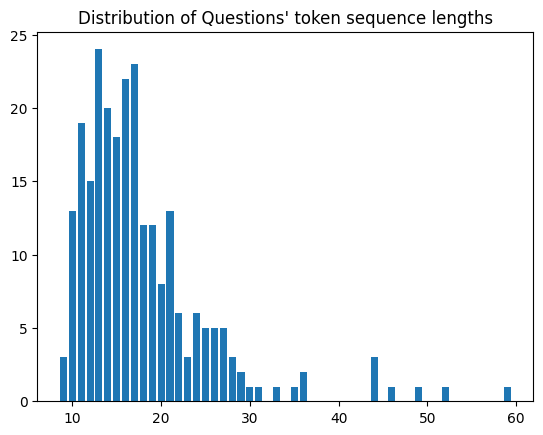

q-mean : 17.78, q-std : 7.46
q-max : 59 , q-min : 9


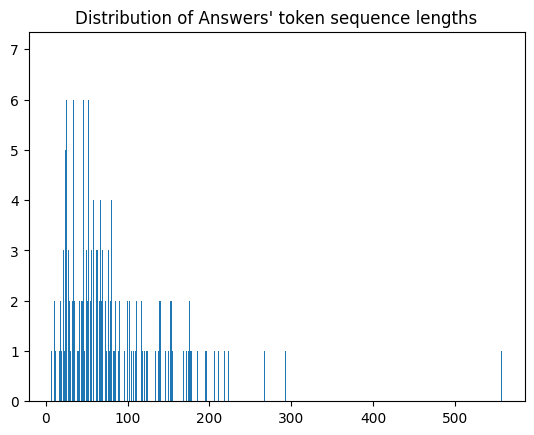

a-mean : 79.57, a-std : 60.02
a-max : 557 , a-min : 7


In [7]:
# Visualizing the dataset
data = []
for index, row in df.iterrows():
  data += [{'question': row.iloc[0], 'answer' : row.iloc[1]}]

enc = tiktoken.get_encoding("gpt2")
q = []; a = []
for qna in data:
  q.append(len((enc.encode(f"Q: {qna['question']} A: "))))
  a.append(len((enc.encode(qna['answer']))))

dq = {}; da = {}
for out in q:
  dq[out] = dq.get(out, 0) + 1
dist_q = dict(sorted(dq.items())) # sort based on keys

for out in a:
  da[out] = da.get(out, 0) + 1
dist_a = dict(sorted(da.items()))

kq = list(dist_q.keys())
vq = list(dist_q.values())

fig, ax = plt.subplots()
bars = ax.bar(kq, vq)
ax.set_title("Distribution of Questions' token sequence lengths")
plt.show()

print(f"q-mean : {statistics.mean(q):.2f}, q-std : {statistics.stdev(q):.2f}")
print(f"q-max : {max(q)} , q-min : {min(q)}")

ka = list(dist_a.keys())
va = list(dist_a.values())

fig, ax = plt.subplots()
bars = ax.bar(ka, va)
ax.set_title("Distribution of Answers' token sequence lengths")
plt.show()

print(f"a-mean : {statistics.mean(a):.2f}, a-std : {statistics.stdev(a):.2f}")
print(f"a-max : {max(a)} , a-min : {min(a)}")

In [8]:
# Improrting the model form Hugging face

# Load the tokenizer and model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

124,439,808 total parameters.
124,439,808 training parameters.


In [11]:
#  ZERO SHOT TESTING with random prompt

#Define your input text
input_text = "What is out-of-core learning?"
input_ids = tokenizer.encode(input_text,
                             max_length=512,
                             truncation=True,
                             return_tensors='pt',
                             ).to(device)

# Create an attention mask and move it to the same device
attention_mask = torch.ones(input_ids.shape, device=device)

# Generate text
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens = 50,
    top_p=0.9,
    top_k=50
)

# Decode the generated text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

What is out-of-core learning?

The main goal of this course is to provide a comprehensive overview of the core concepts of learning. This course is designed to be a comprehensive overview of the core concepts of learning. This course is designed to be a comprehensive overview of the core concepts


In [12]:
# split into train and val data
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"train data : {len(train_data)}, val data: {len(val_data)}")
train_data[:2]

train data : 225, val data: 25


[{'question': 'How would you define machine learning?',
  'answer': 'Machine Learning is about building systems that can learn from data. Learning means getting better at some task, given some performance measure.'},
 {'question': 'Can you name four types of applications where it shines?',
  'answer': 'Machine Learning is great for complex problems for which we have no algorithmic solution, to replace long lists of hand-tuned rules, to build systems that adapt to fluctuating environments, and finally to help humans learn (e.g., data mining).'}]

In [13]:
import json
with open('train_file.json', 'w') as file:
    json.dump(train_data, file)
with open('val_file.json', 'w') as file:
    json.dump(val_data, file)

In [14]:
# Tokenize the dataset
from datasets import load_dataset
dataset = load_dataset('json', data_files = {'train':'train_file.json' , 'test':'val_file.json'})
tokenizer.pad_token = tokenizer.eos_token
def preprocess_function(examples):
    inputs = [q + tokenizer.eos_token + a for q, a in zip(examples['question'], examples['answer'])]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    labels = model_inputs['input_ids'].copy()
    model_inputs['labels'] = labels
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [15]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",    # output directory
    overwrite_output_dir=True,        # output directory
    num_train_epochs=10,              # number of epochs
    per_device_train_batch_size=4,    # batch size for training
    per_device_eval_batch_size=4,     # batch size for evaluation
    eval_strategy="epoch",            # evaluate every epoch
    logging_dir="./logs",
    logging_steps=5,
    save_strategy="epoch",            # save checkpoints at end of epoch
    save_total_limit=1,               # save only latest check point
    prediction_loss_only = True       # Ensures only loss is computed during evaluation
    #load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
)

# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.925900,1.374440
2,0.776400,1.384413
3,0.780000,1.417073
4,0.656700,1.469532
5,0.604400,1.493474
6,0.729400,1.520080
7,0.444600,1.553281
8,0.569900,1.570285
9,0.535100,1.591470
10,0.731700,1.600837


TrainOutput(global_step=570, training_loss=0.735585914369215, metrics={'train_runtime': 281.9008, 'train_samples_per_second': 7.982, 'train_steps_per_second': 2.022, 'total_flos': 293953536000000.0, 'train_loss': 0.735585914369215, 'epoch': 10.0})

In [16]:
# Generate answers from the validation dataset
model.eval()
generated_answers = []
for example in val_data:
    input_ids = tokenizer.encode(example['question'], return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, device=device)
    output = model.generate(input_ids, attention_mask = attention_mask, max_length=50)
    generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_answers.append(generated_answer)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [17]:
# Calculate ROUGE scores
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = []
for i, example in enumerate(val_data):
    target_answer = example['answer']
    generated_answer = generated_answers[i]
    scores = scorer.score(target_answer, generated_answer)
    rouge_scores.append(scores)

# Print average ROUGE scores
avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-2 Score: {avg_rouge2}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

Average ROUGE-1 Score: 0.2041372288839562
Average ROUGE-2 Score: 0.10648781030859134
Average ROUGE-L Score: 0.19217790811686503


In [22]:
# Human Evaluation

def ask_question(question):
    inputs = tokenizer.encode(f"Q: {question} A: ", return_tensors='pt').to(device)
    attention_mask = torch.ones(inputs.shape, device=device)
    outputs = model.generate(inputs, attention_mask = attention_mask, max_length=100, num_return_sequences=1)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

print(ask_question("What is the curse of dimensionality?"))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: What is the curse of dimensionality? A:  The curse of dimensionality is a fundamental problem in computer vision. It prevents the model from growing too large, leading to poor performance, poor performance in tasks like image recognition, and possibly even loss of dimensionality.


In [21]:
model_name = "gpt2_for_q_and_a"  # Choose a name for your model
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/paramasivan27/gpt2_for_q_and_a/commit/511d69feafa04bf5978c16c8418fd4d83e432c37', commit_message='Upload tokenizer', commit_description='', oid='511d69feafa04bf5978c16c8418fd4d83e432c37', pr_url=None, pr_revision=None, pr_num=None)